In [34]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt

INITIAL - SALE DATA

In [3]:
sale_df = pd.read_csv('../data/iProperty_sale_to_be_trained.csv')

sale_df.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = sale_df[col].quantile(0.01)
    q_hi  = sale_df[col].quantile(0.99)
    sale_df = sale_df[(sale_df[col] < q_hi) & (sale_df[col] > q_low)]
    
one_hot = pd.get_dummies(sale_df[['district','state','type','details']])
sale_df = sale_df.join(one_hot).drop(['district','state','type','details'], axis=1)

for num in sale_df.drop(['price'], axis=1).dtypes[(sale_df.dtypes == "int64")].index:
    MMS = MinMaxScaler()
    MMS.fit(sale_df[[num]])
    sale_df[num] = MMS.transform(sale_df[[num]])
    
sale_x = sale_df.drop(['price'],axis=1)
sale_y = sale_df['price']

sale_x_train, sale_x_test, sale_y_train, sale_y_test = train_test_split(sale_x,sale_y,test_size=0.2)

In [2]:
SEED=42
models = {
#     'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=SEED),
    'Random Forest': RandomForestRegressor(random_state=SEED),
    'Support Vector Machine': SVR(),
#     'K Neighbors': KNeighborsRegressor(),
    'Gradient Boost': GradientBoostingRegressor(random_state=SEED),
    'Neural Network': MLPRegressor(random_state=SEED),
}

1. CROSS VAL SCORE

In [4]:
# for key, value in models.items():
#     print(key)
#     print(cross_val_score(value, sale_x, sale_y, cv=5, n_jobs=-1))
#     print('==='*20, '\n')

2. Train Score, Test Score, R2, RMSE, MAE, MAPE

In [5]:
score_init = {
    'score':['train','test','R2','RMSE','MAE','MAPE']
}

In [6]:
for key, value in models.items():
    model = value
    model.fit(sale_x_train,sale_y_train)
    sale_y_pred = model.predict(sale_x_test)
    
    score_init[key] = []
    score_init[key].append(model.score(sale_x_train,sale_y_train))
    score_init[key].append(model.score(sale_x_test,sale_y_test))
    score_init[key].append(r2_score(sale_y_test,sale_y_pred))
    score_init[key].append(mean_squared_error(sale_y_test,sale_y_pred, squared=False))
    score_init[key].append(mean_absolute_error(sale_y_test,sale_y_pred))
    score_init[key].append(mean_absolute_percentage_error(sale_y_test,sale_y_pred))
    print(key + ': Score is ready')

Decision Tree: Score is ready
Random Forest: Score is ready
Support Vector Machine: Score is ready
Gradient Boost: Score is ready
Neural Network: Score is ready


C:\Users\DS\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [7]:
init_df = pd.DataFrame(score_init).T
init_df.columns = init_df.iloc[0]
init_df = init_df[1:]
init_df = init_df.reset_index()
init_df.rename(columns={'index':'model'}, inplace=True)
init_df

score,model,train,test,R2,RMSE,MAE,MAPE
0,Decision Tree,0.968647,0.674265,0.674265,600184.851039,290013.147415,0.272926
1,Random Forest,0.944818,0.781429,0.781429,491641.87304,254233.15772,0.245731
2,Support Vector Machine,-0.119964,-0.127521,-0.127521,1116645.351789,622845.178093,0.617198
3,Gradient Boost,0.764633,0.744513,0.744513,531541.314204,307770.789254,0.33817
4,Neural Network,-0.980161,-0.969948,-0.969948,1475979.678781,1035860.561722,0.986429


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

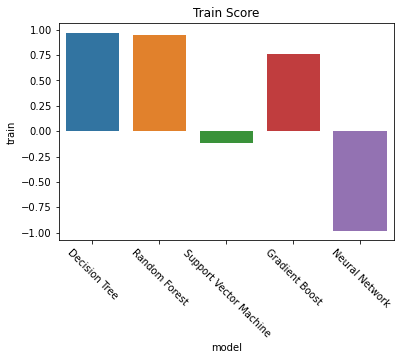

In [8]:
p = sns.barplot(data=init_df, x='model', y='train')
p.set_title('Train Score')
plt.xticks(rotation=-45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

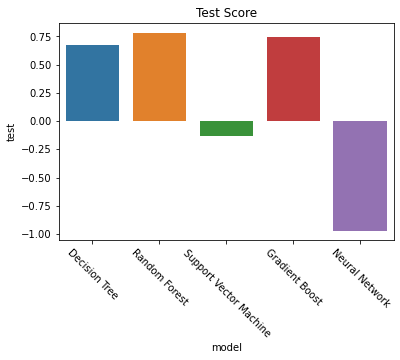

In [9]:
p = sns.barplot(data=init_df, x='model', y='test')
p.set_title('Test Score')
plt.xticks(rotation=-45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

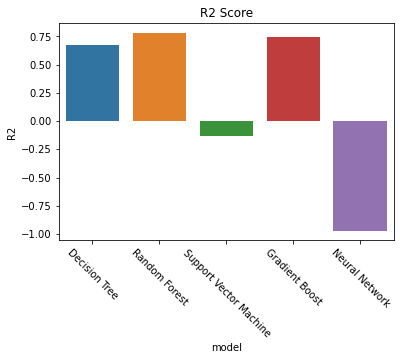

In [10]:
p = sns.barplot(data=init_df, x='model', y='R2')
p.set_title('R2 Score')
plt.xticks(rotation=-45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

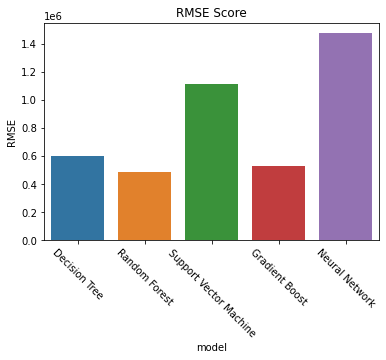

In [11]:
p = sns.barplot(data=init_df, x='model', y='RMSE')
p.set_title('RMSE Score')
plt.xticks(rotation=-45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

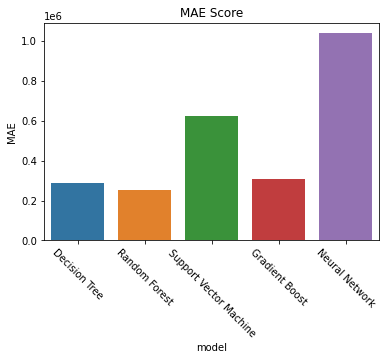

In [12]:
p = sns.barplot(data=init_df, x='model', y='MAE')
p.set_title('MAE Score')
plt.xticks(rotation=-45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

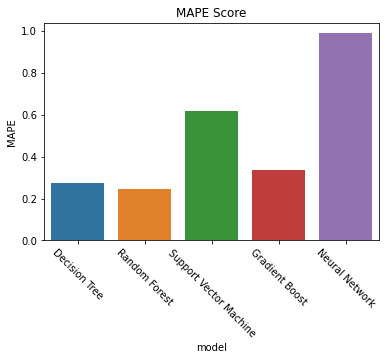

In [13]:
p = sns.barplot(data=init_df, x='model', y='MAPE')
p.set_title('MAPE Score')
plt.xticks(rotation=-45)

WITH PARAMETERS

In [14]:
# lr_hyperparameters = {}

dt_hyperparameters = {}

rf_hyperparameters = {
    'n_estimators' : 100
}

svr_hyperparameters = {}

# kn_hyperparameters = {}

gb_hyperparameters = {
    'n_estimators' : 100,
    'learning_rate' : 0.1,
    'max_depth' : 3,
}

nn_hyperparameters = {'hidden_layer_sizes' : (80,40,20,10)}

hyperparameters = {
#     'Linear Regression': lr_hyperparameters,
    'Decision Tree': dt_hyperparameters,
    'Random Forest': rf_hyperparameters,
    'Support Vector Machine': svr_hyperparameters,
#     'K Neighbors': kn_hyperparameters,
    'Gradient Boost': gb_hyperparameters,
    'Neural Network': nn_hyperparameters,
}

1. CROSS VAL SCORE

In [15]:
# for key, value in models.items():
#     model = value
#     model.set_params(**hyperparameters[key])
#     print(key)
#     print(cross_val_score(model, sale_x, sale_y, cv=5, n_jobs=-1))
#     print('==='*20, '\n')

In [16]:
score_param = {
    'score':['train','test','R2','RMSE','MAE','MAPE']
}

In [18]:
for key, value in models.items():
    model = value
    model.set_params(**hyperparameters[key])
    model.fit(sale_x_train,sale_y_train)
    sale_y_pred = model.predict(sale_x_test)
    
    score_param[key] = []
    score_param[key].append(model.score(sale_x_train,sale_y_train))
    score_param[key].append(model.score(sale_x_test,sale_y_test))
    score_param[key].append(r2_score(sale_y_test,sale_y_pred))
    score_param[key].append(mean_squared_error(sale_y_test,sale_y_pred, squared=False))
    score_param[key].append(mean_absolute_error(sale_y_test,sale_y_pred))
    score_param[key].append(mean_absolute_percentage_error(sale_y_test,sale_y_pred))
    print(key + ': Score is ready')

Decision Tree: Score is ready
Random Forest: Score is ready
Support Vector Machine: Score is ready
Gradient Boost: Score is ready
Neural Network: Score is ready


C:\Users\DS\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
param_df = pd.DataFrame(score_param).T
param_df.columns = param_df.iloc[0]
param_df = param_df[1:]
param_df = param_df.reset_index()
param_df.rename(columns={'index':'model'}, inplace=True)
param_df

score,model,train,test,R2,RMSE,MAE,MAPE
0,Decision Tree,0.968647,0.674265,0.674265,600184.851039,290013.147415,0.272926
1,Random Forest,0.944818,0.781429,0.781429,491641.87304,254233.15772,0.245731
2,Support Vector Machine,-0.119964,-0.127521,-0.127521,1116645.351789,622845.178093,0.617198
3,Gradient Boost,0.764633,0.744513,0.744513,531541.314204,307770.789254,0.33817
4,Neural Network,0.803764,0.784779,0.784779,487860.696777,263308.241505,0.270017


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

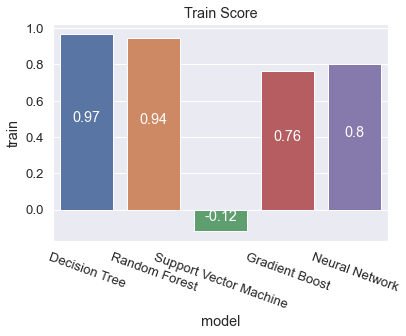

In [53]:
p = sns.barplot(data=param_df, x='model', y='train')
p.set_title('Train Score')
for i in range(len(param_df)):
    p.text(i,param_df.train[i]/2,str(round(param_df.train[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

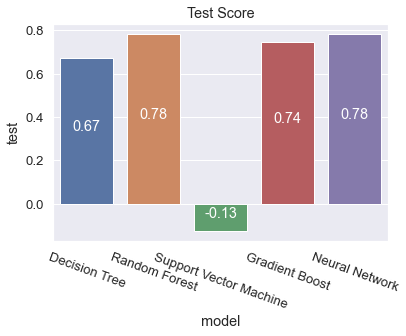

In [54]:
p = sns.barplot(data=param_df, x='model', y='test')
p.set_title('Test Score')
for i in range(len(param_df)):
    p.text(i,param_df.test[i]/2,str(round(param_df.test[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

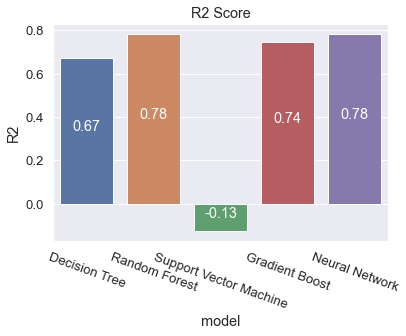

In [56]:
p = sns.barplot(data=param_df, x='model', y='R2')
p.set_title('R2 Score')
for i in range(len(param_df)):
    p.text(i,param_df.R2[i]/2,str(round(param_df.R2[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

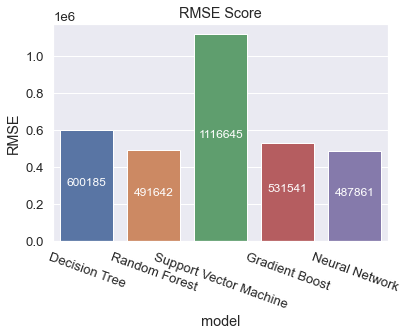

In [60]:
p = sns.barplot(data=param_df, x='model', y='RMSE')
p.set_title('RMSE Score')
for i in range(len(param_df)):
    p.text(i,param_df.RMSE[i]/2,str(round(param_df.RMSE[i])),
           fontdict=dict(color='white', fontsize=12),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

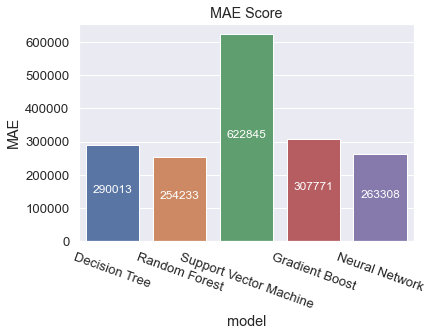

In [62]:
p = sns.barplot(data=param_df, x='model', y='MAE')
p.set_title('MAE Score')
for i in range(len(param_df)):
    p.text(i,param_df.MAE[i]/2,str(round(param_df.MAE[i])),
           fontdict=dict(color='white', fontsize=12),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network')])

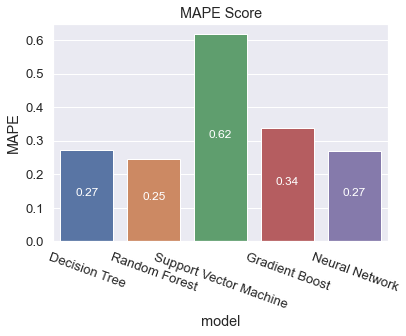

In [64]:
p = sns.barplot(data=param_df, x='model', y='MAPE')
p.set_title('MAPE Score')
for i in range(len(param_df)):
    p.text(i,param_df.MAPE[i]/2,str(round(param_df.MAPE[i],2)),
           fontdict=dict(color='white', fontsize=12),
          horizontalalignment='center')
plt.xticks(rotation=-20)